# Intrinsic Dimension of Neural Representations  
# 神经网络表征的内在维度分析

$\textbf{Lead Author:}$ Nmhkck  

Inspired by: DeepCT Metric Framework, Geomstats (Adele Myers, 2022)  

$\textit{Note:}$ 运行以下代码以导入必要的依赖包，保证后续单元格的正常运行。


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from deepct.metrics.layer_representation_intrinsic_dimension import LayerRepresentationIntrinsicDimension

# 设置随机种子，保证实验可复现
torch.manual_seed(2025)
np.random.seed(2025)

print("环境初始化完成 ✅")

# 1. Introduction  
# 引言


Welcome to the *Intrinsic Dimension Analysis* notebook!  
In this notebook, we will explore the concept of **Intrinsic Dimension (ID)** in neural network representations —  
a quantitative measure of how “complex” or “compressed” a model’s learned feature space truly is.  

We will base our implementation on the `LayerRepresentationIntrinsicDimension` metric recently added to the **DeepCT** framework.  
This metric is inspired by the *Participation Ratio* formulation used in representation geometry and manifold analysis.  

In this notebook, you will learn:

1. What is *Intrinsic Dimension* (ID)?  
2. Why is ID important for understanding neural representations?  
3. How is ID mathematically defined and computed?  
4. How is it implemented in the DeepCT metric framework?  
5. What patterns appear across layers in different model families (e.g., Qwen2.5, DeepSeek-R1, LLaMA3)?

---

欢迎来到《神经网络表征的内在维度分析》Notebook！  
在本笔记中，我们将介绍神经网络表征的内在维度（Intrinsic Dimension, ID）概念，  
并基于 DeepCT 框架中新增的 `LayerRepresentationIntrinsicDimension` 模块进行实现与可视化。  

本节内容将带你了解：
1. 什么是内在维度；
2. 为什么内在维度对理解模型结构至关重要；
3. 它的数学定义与计算方式；
4. 在 DeepCT 框架中的具体实现；
5. 不同大模型（如 Qwen2.5、DeepSeek-R1、LLaMA3）之间的层间差异模式。


# 2. What is Intrinsic Dimension (ID)?  
# 什么是内在维度（Intrinsic Dimension, ID）？


**Intuition:**  
When studying neural networks, we often imagine that high-dimensional representations (such as hidden layer activations)  
actually live on a much lower-dimensional surface — a *representation manifold*.  
The **Intrinsic Dimension (ID)** aims to measure the “effective” number of degrees of freedom in this representation space.  

In simpler terms, ID tells us *how many directions actually matter* when the model processes information.  
For example, a large model might have 4096 hidden features, but only a few hundred independent directions truly capture its knowledge.

We can think of ID as the “information-carrying thickness” of a neural representation.  
The smaller the ID, the more redundant or correlated the feature space becomes —  
indicating compression, specialization, or saturation effects in deep layers.

---

**直觉说明：**  
在神经网络中，我们通常认为模型的高维表示（例如隐藏层激活）  
实际上分布在一个低维的“表示流形”上。  
**内在维度（Intrinsic Dimension, ID）** 用于刻画这一表示空间中真正独立变化的“有效自由度”数量。

换句话说，ID 告诉我们——模型的特征空间中，有多少维度真的在承载信息。  
例如，一个隐藏层有 4096 个特征维度，但真正有用的独立方向可能只有几百个。

较小的 ID 值意味着表示空间存在冗余或高度相关性，  
这通常对应于网络后期的压缩、专化或饱和特征。

---



## 2.1 Mathematical Definition  
## 数学定义


Mathematically, the Intrinsic Dimension is commonly estimated using the **Participation Ratio (PR)**:  

$$
ID = \frac{\left(\sum_i s_i^2\right)^2}{\sum_i s_i^4}
$$  

where \( s_i \) are the singular values (eigenvalues of the covariance matrix)  
that describe how the variance of the representation is distributed across directions.

The ID can be interpreted as an “effective number of dominant axes”  
that capture most of the data’s variance in hidden space.

---

**数学定义：**  
内在维度可以通过参与比（Participation Ratio, PR）进行估计：

$$
ID = \frac{(\sum_i s_i^2)^2}{\sum_i s_i^4}
$$

其中，\( s_i \) 表示样本协方差矩阵的奇异值或特征值，  
反映了数据在不同方向上的方差分布情况。  
该指标可以理解为“有效主方向的数量”，即表示空间中真正主导变化的轴数。

---


## 2.2 Geometric Intuition  
## 几何直观解释


Imagine each hidden representation as a point cloud in a high-dimensional space.  
If these points are scattered evenly in all directions, ID will be high;  
if they collapse along a few dominant directions, ID becomes small.

*Insert illustration here:*  
> “A conceptual diagram comparing high-ID vs low-ID feature spaces (e.g., a wide cloud vs. a compressed elongated cluster).”

---

**几何直观解释：**  
可以把每个隐藏层的表示看作是高维空间中的点云。  
如果点在各个方向上分布均匀，则内在维度较高；  
若它们集中在少数方向上，则内在维度较低。

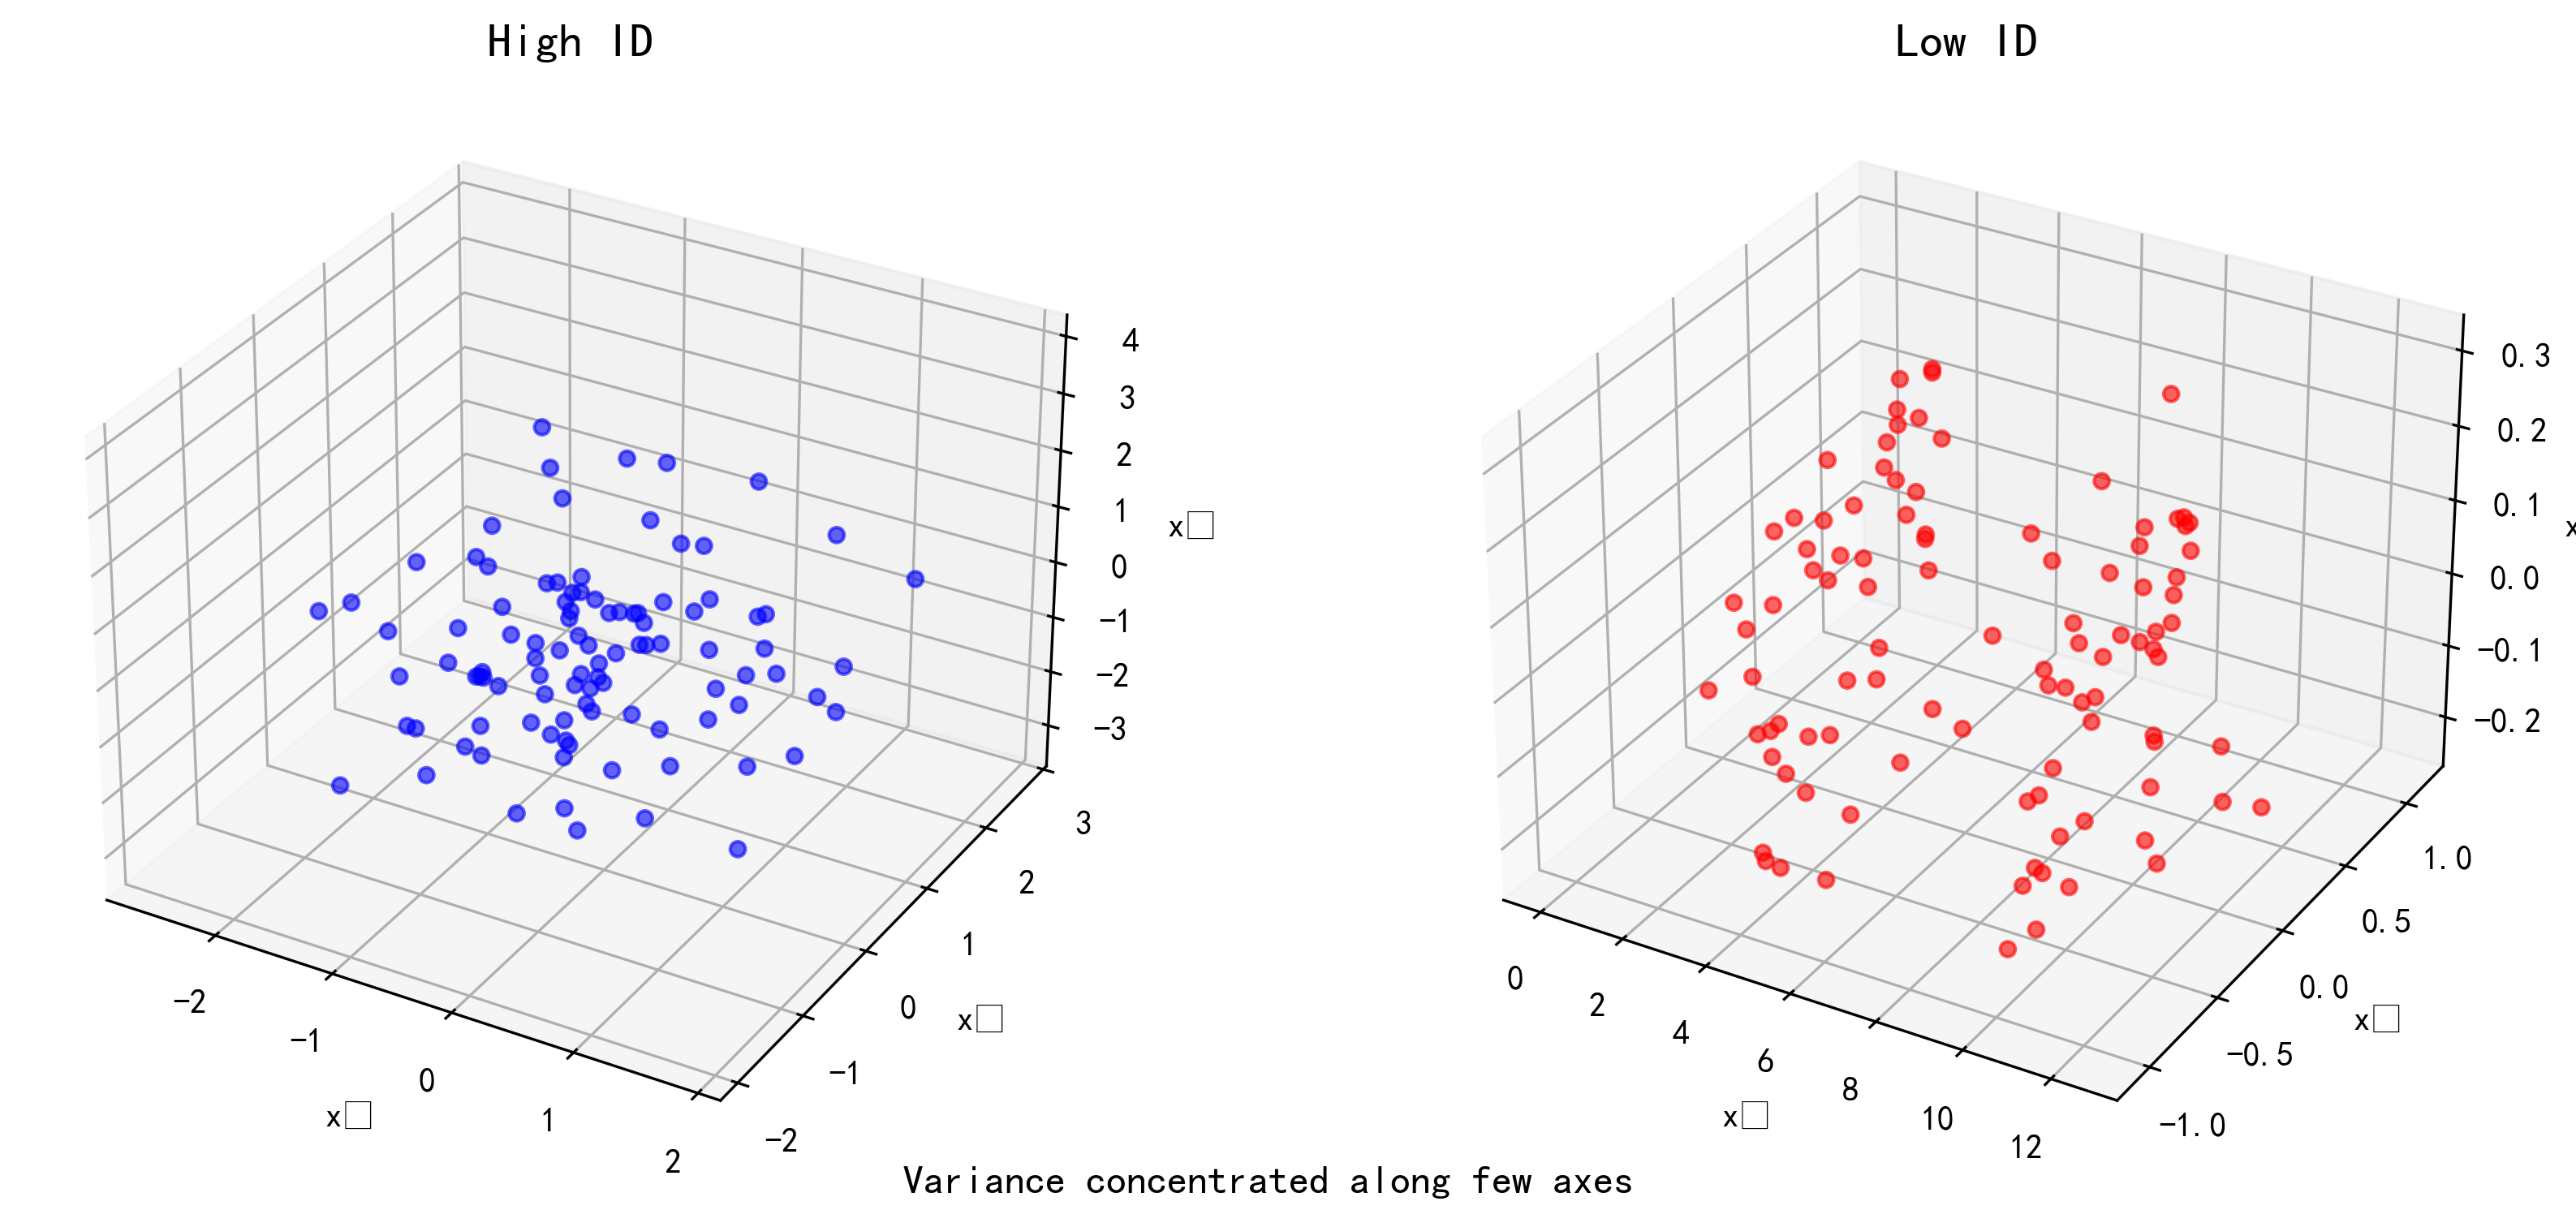

---


## 2.3 Simple Example: Low-rank Feature Space  
## 简单例子：低秩特征空间


Here, we illustrate how Intrinsic Dimension (ID) behaves  
when the feature representations are restricted to a lower-dimensional subspace.

Consider a simple set of 2D data points that lie approximately on a straight line.  
Even though the embedding space is 2-dimensional, the data effectively varies along one direction only —  
thus, the intrinsic dimension ≈ 1.

Mathematically, if we compute the singular values of the covariance matrix  
and find that only one is significantly nonzero,  
then the participation ratio gives \( ID \approx 1 \).

---

**直观解释：**  
我们举一个简单的二维例子。  
假设样本点虽然在二维平面中，但几乎都沿着一条直线分布。  
此时，虽然空间是 2D，但有效变化的方向只有 1 个，  
因此内在维度大约为 1。

---

*Insert illustration here:*  
> A 2D scatter plot where points lie along a diagonal line.  
> Label: “High correlation → Low intrinsic dimension (≈ 1)”.

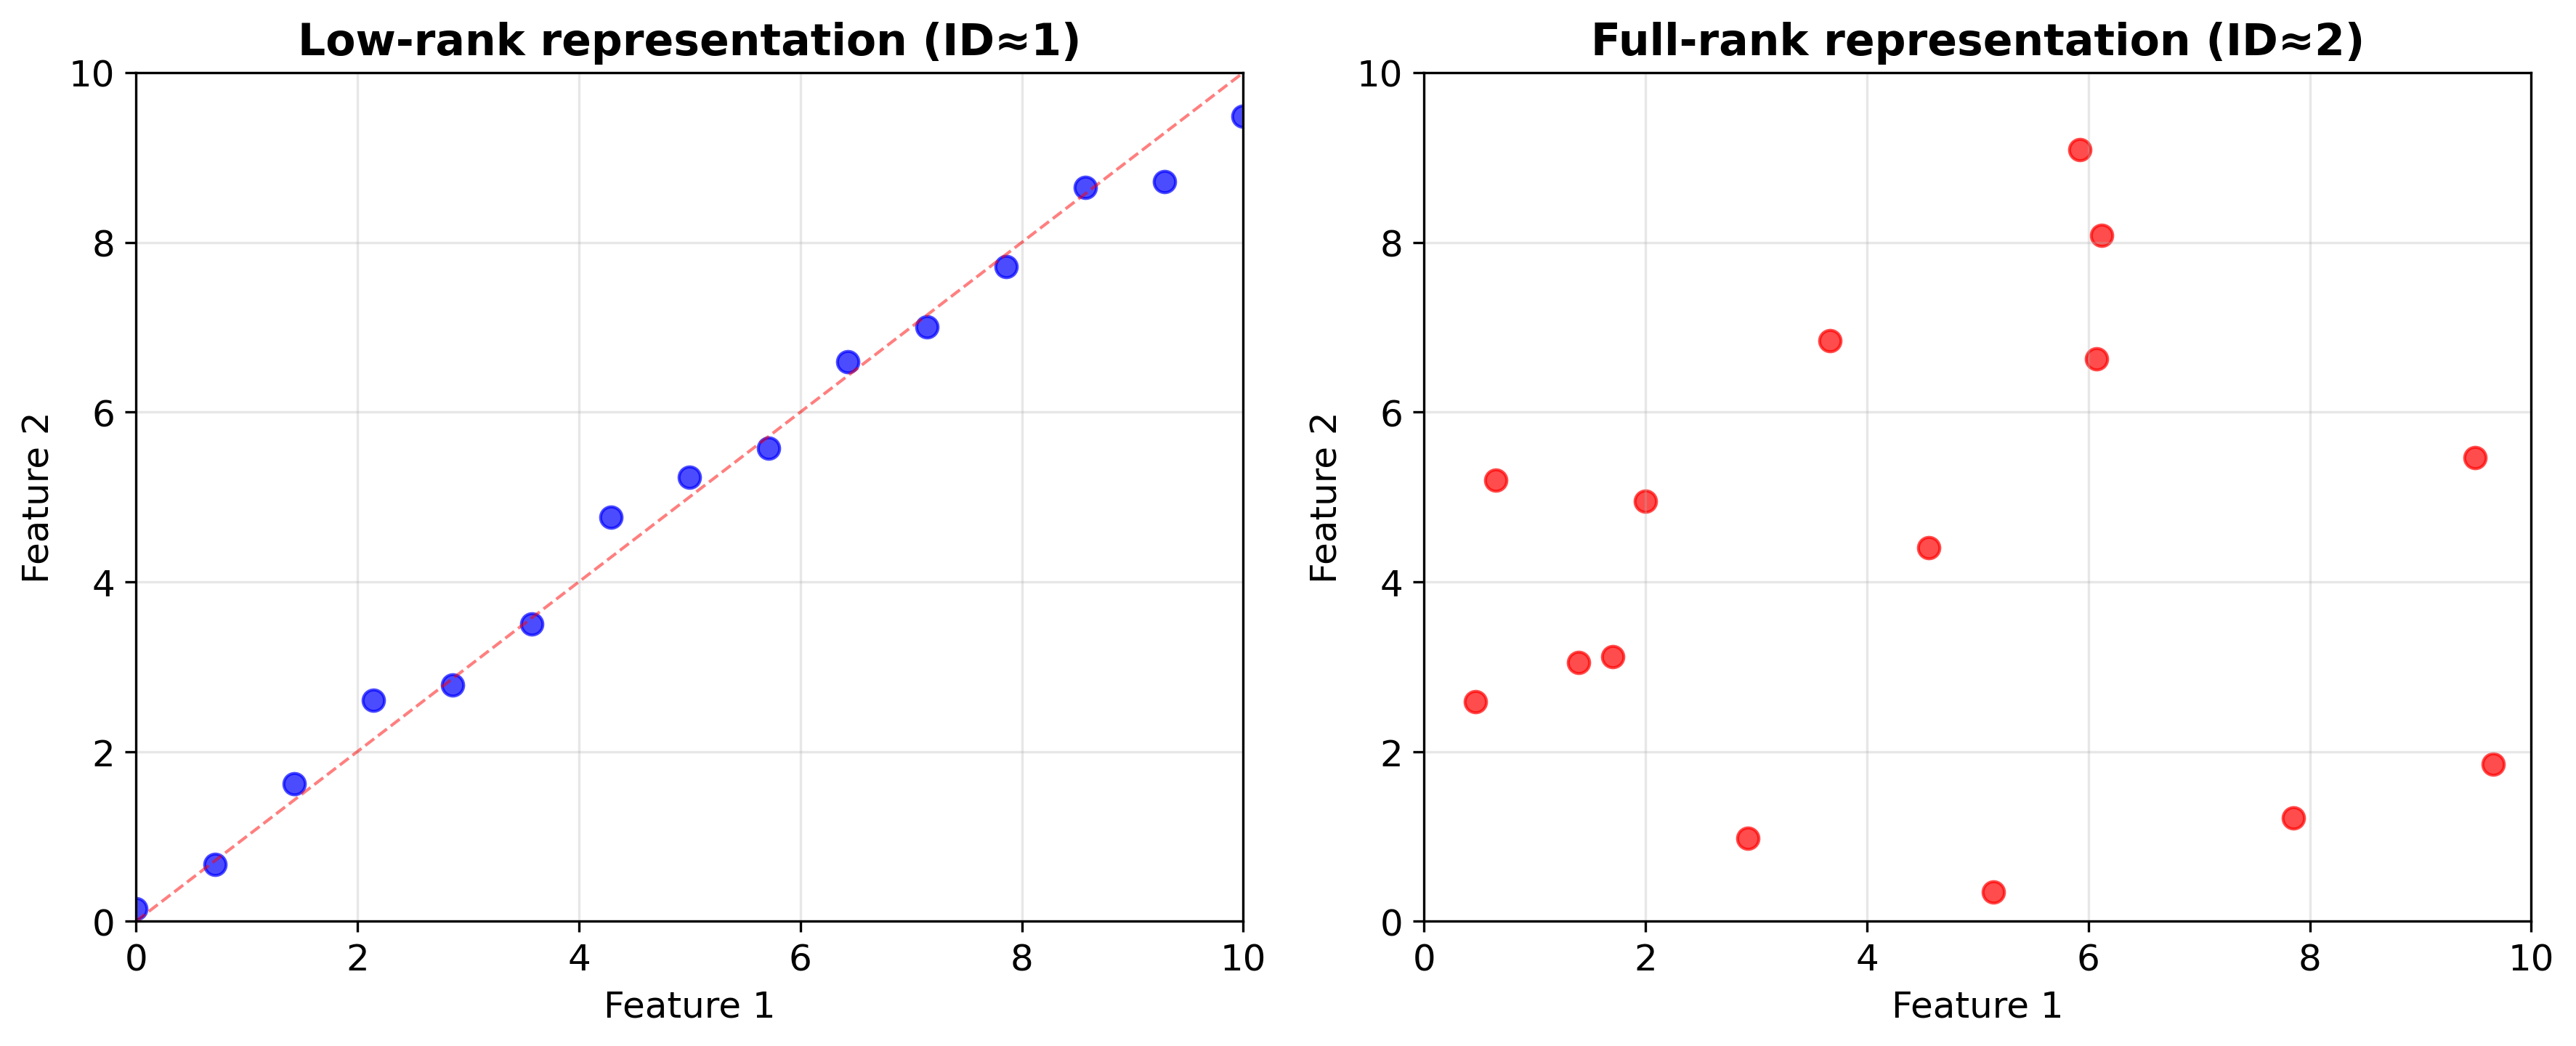



## 2.4 More Examples of Representation Manifolds  
## 更多表示流形的例子


While the low-rank example above shows a simple linear structure,  
real neural networks form much more complex **nonlinear manifolds**.  
Here we illustrate several common patterns of representation geometry observed in large models:

1. **Spherical cloud:** Early layers (e.g., embedding space) where features are isotropic.  
2. **Elliptical tube:** Middle layers that begin compressing and aligning features along key directions.  
3. **Flattened cluster:** Deep layers where variance collapses — the representation becomes highly specialized.

---

**进一步的例子：**  
在上一个低秩例子中，我们看到了一种简单的线性压缩。  
但在真实的大模型中，特征分布往往呈现更复杂的非线性形态。  
例如：
1. **球形点云：** 表示层初期，特征在各个方向上均匀分布；  
2. **椭圆形管状：** 中间层开始压缩、对齐主要方向；  
3. **扁平团簇：** 深层方差塌缩，表示趋于专化。

---

*Insert illustrations here:*  
> Three schematic diagrams representing “sphere → ellipse → flat cluster”.

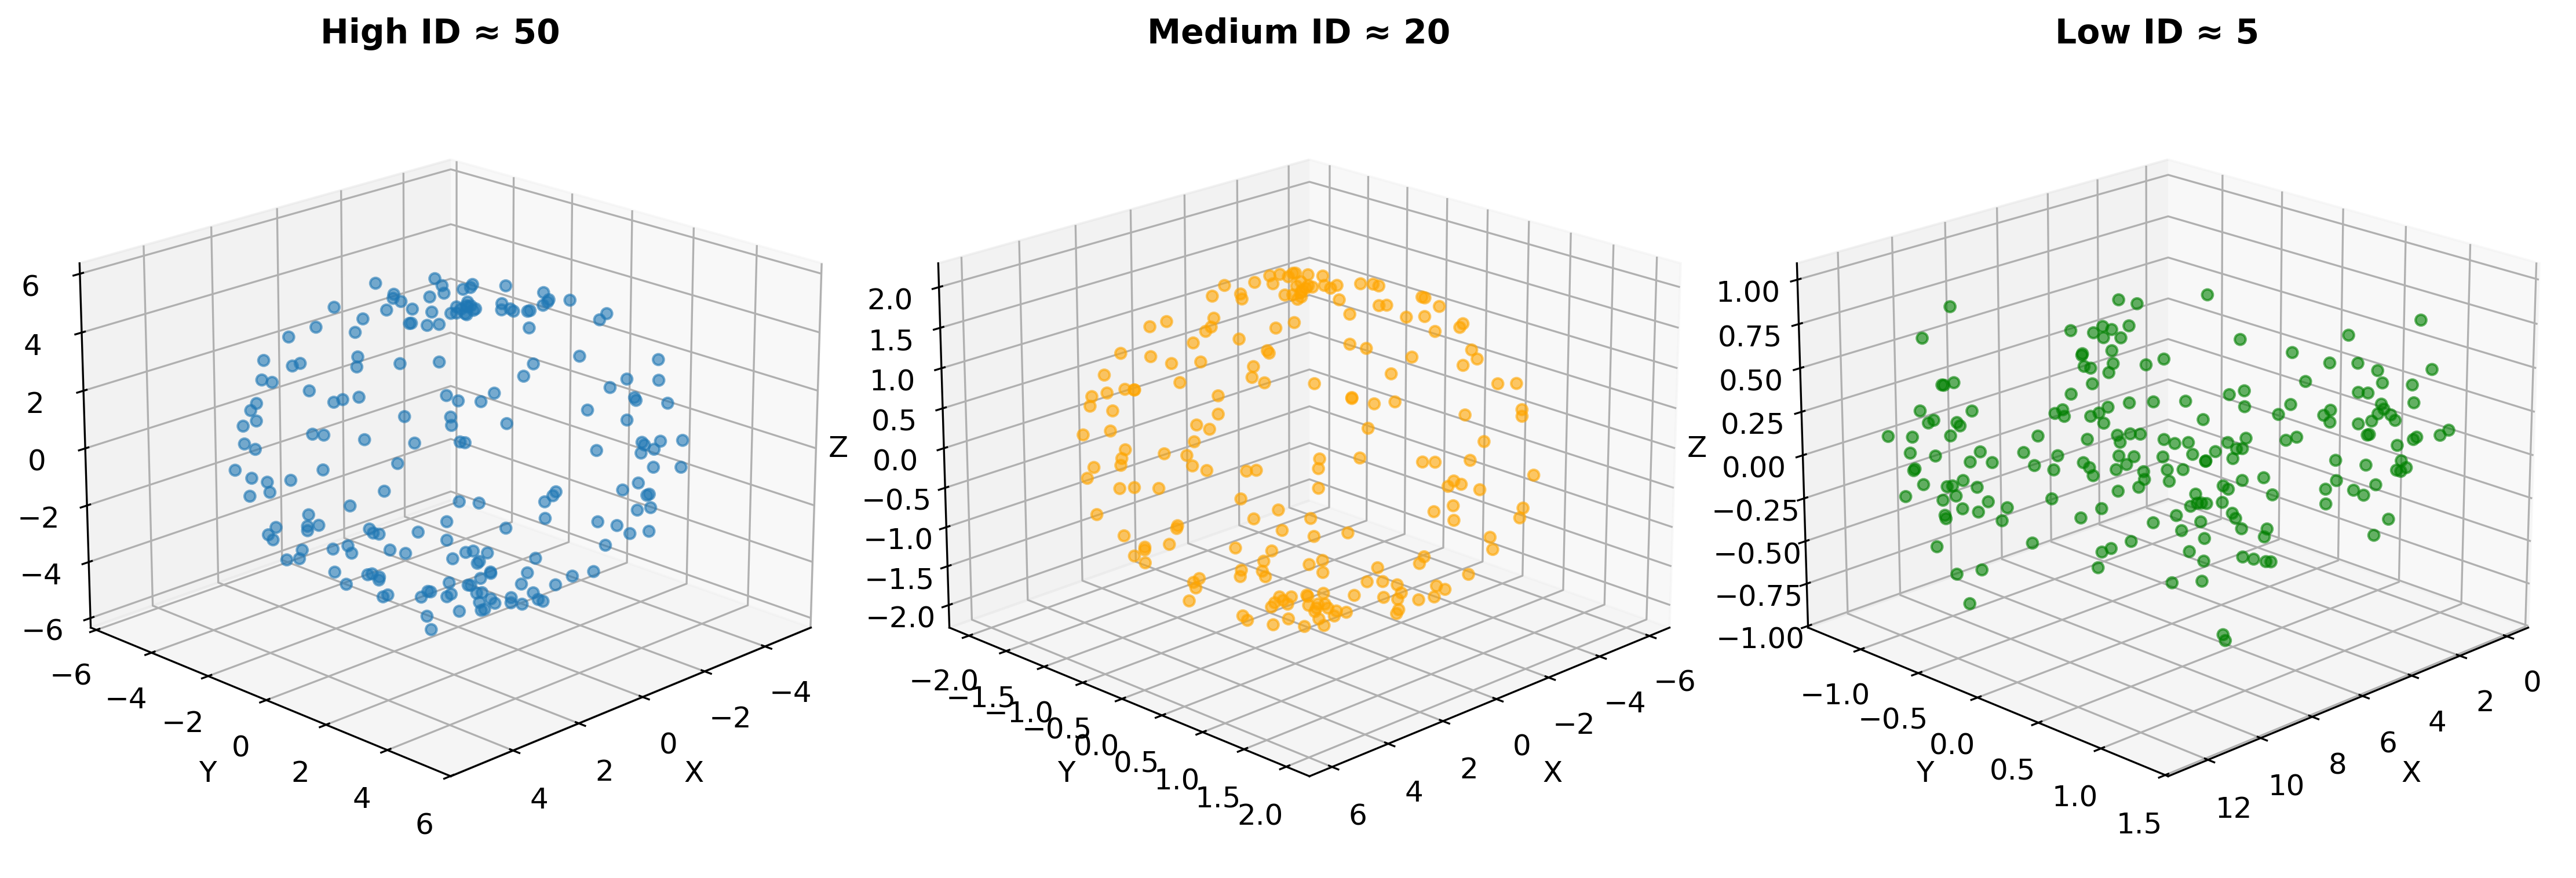



# 3. Why do we care about Intrinsic Dimension (ID)?
# 为什么我们要关注内在维度（ID）？


**Intrinsic Dimension is important because it reveals how complex or compact a model’s internal representations are.**  
Just like data in nature “naturally falls on manifolds,” neural representations tend to evolve toward low-dimensional subspaces during training.  
This property reflects how neural networks balance **expressivity** and **efficiency** — encoding rich semantics while minimizing redundancy.

---

**内在维度之所以重要，是因为它揭示了模型内部表征的复杂度与紧凑度。**  
正如自然界的数据会“自然地落在流形上”，神经网络的特征空间在训练过程中也会逐渐向低维子空间收缩。  
这一现象体现了模型在“表达能力”与“计算效率”之间的平衡：既要能表达复杂语义，又要消除冗余。

---


## 3.1 Why ID matters
## 为什么要研究内在维度


Studying Intrinsic Dimension (ID) allows us to understand the *information geometry* of deep models:  

1. **Representation Compression** – Observe how features are progressively simplified across layers.  
2. **Task Specialization** – Identify which layers encode general vs. task-specific knowledge.  
3. **Architectural Efficiency** – Compare different model families’ ability to retain useful information.

---


研究 ID 能帮助我们理解模型的“信息几何结构”：  

1. **表征压缩**：分析特征在层间如何被简化；  
2. **任务专化**：判断哪些层编码通用知识，哪些层聚焦任务特征；  
3. **结构效率**：比较不同模型架构的信息保持能力。

---


## 3.2 Empirical Observation: Layer-wise ID Collapse  
## 实证观察：层间维度塌缩现象


*Insert Figure: Intrinsic Dimension vs Layer (Linear)*  
> This figure compares the intrinsic dimension across layers for multiple models  
> (Qwen2.5, DeepSeek-R1, and LLaMA3 families).  
> The results demonstrate how representation spaces contract as network depth increases.

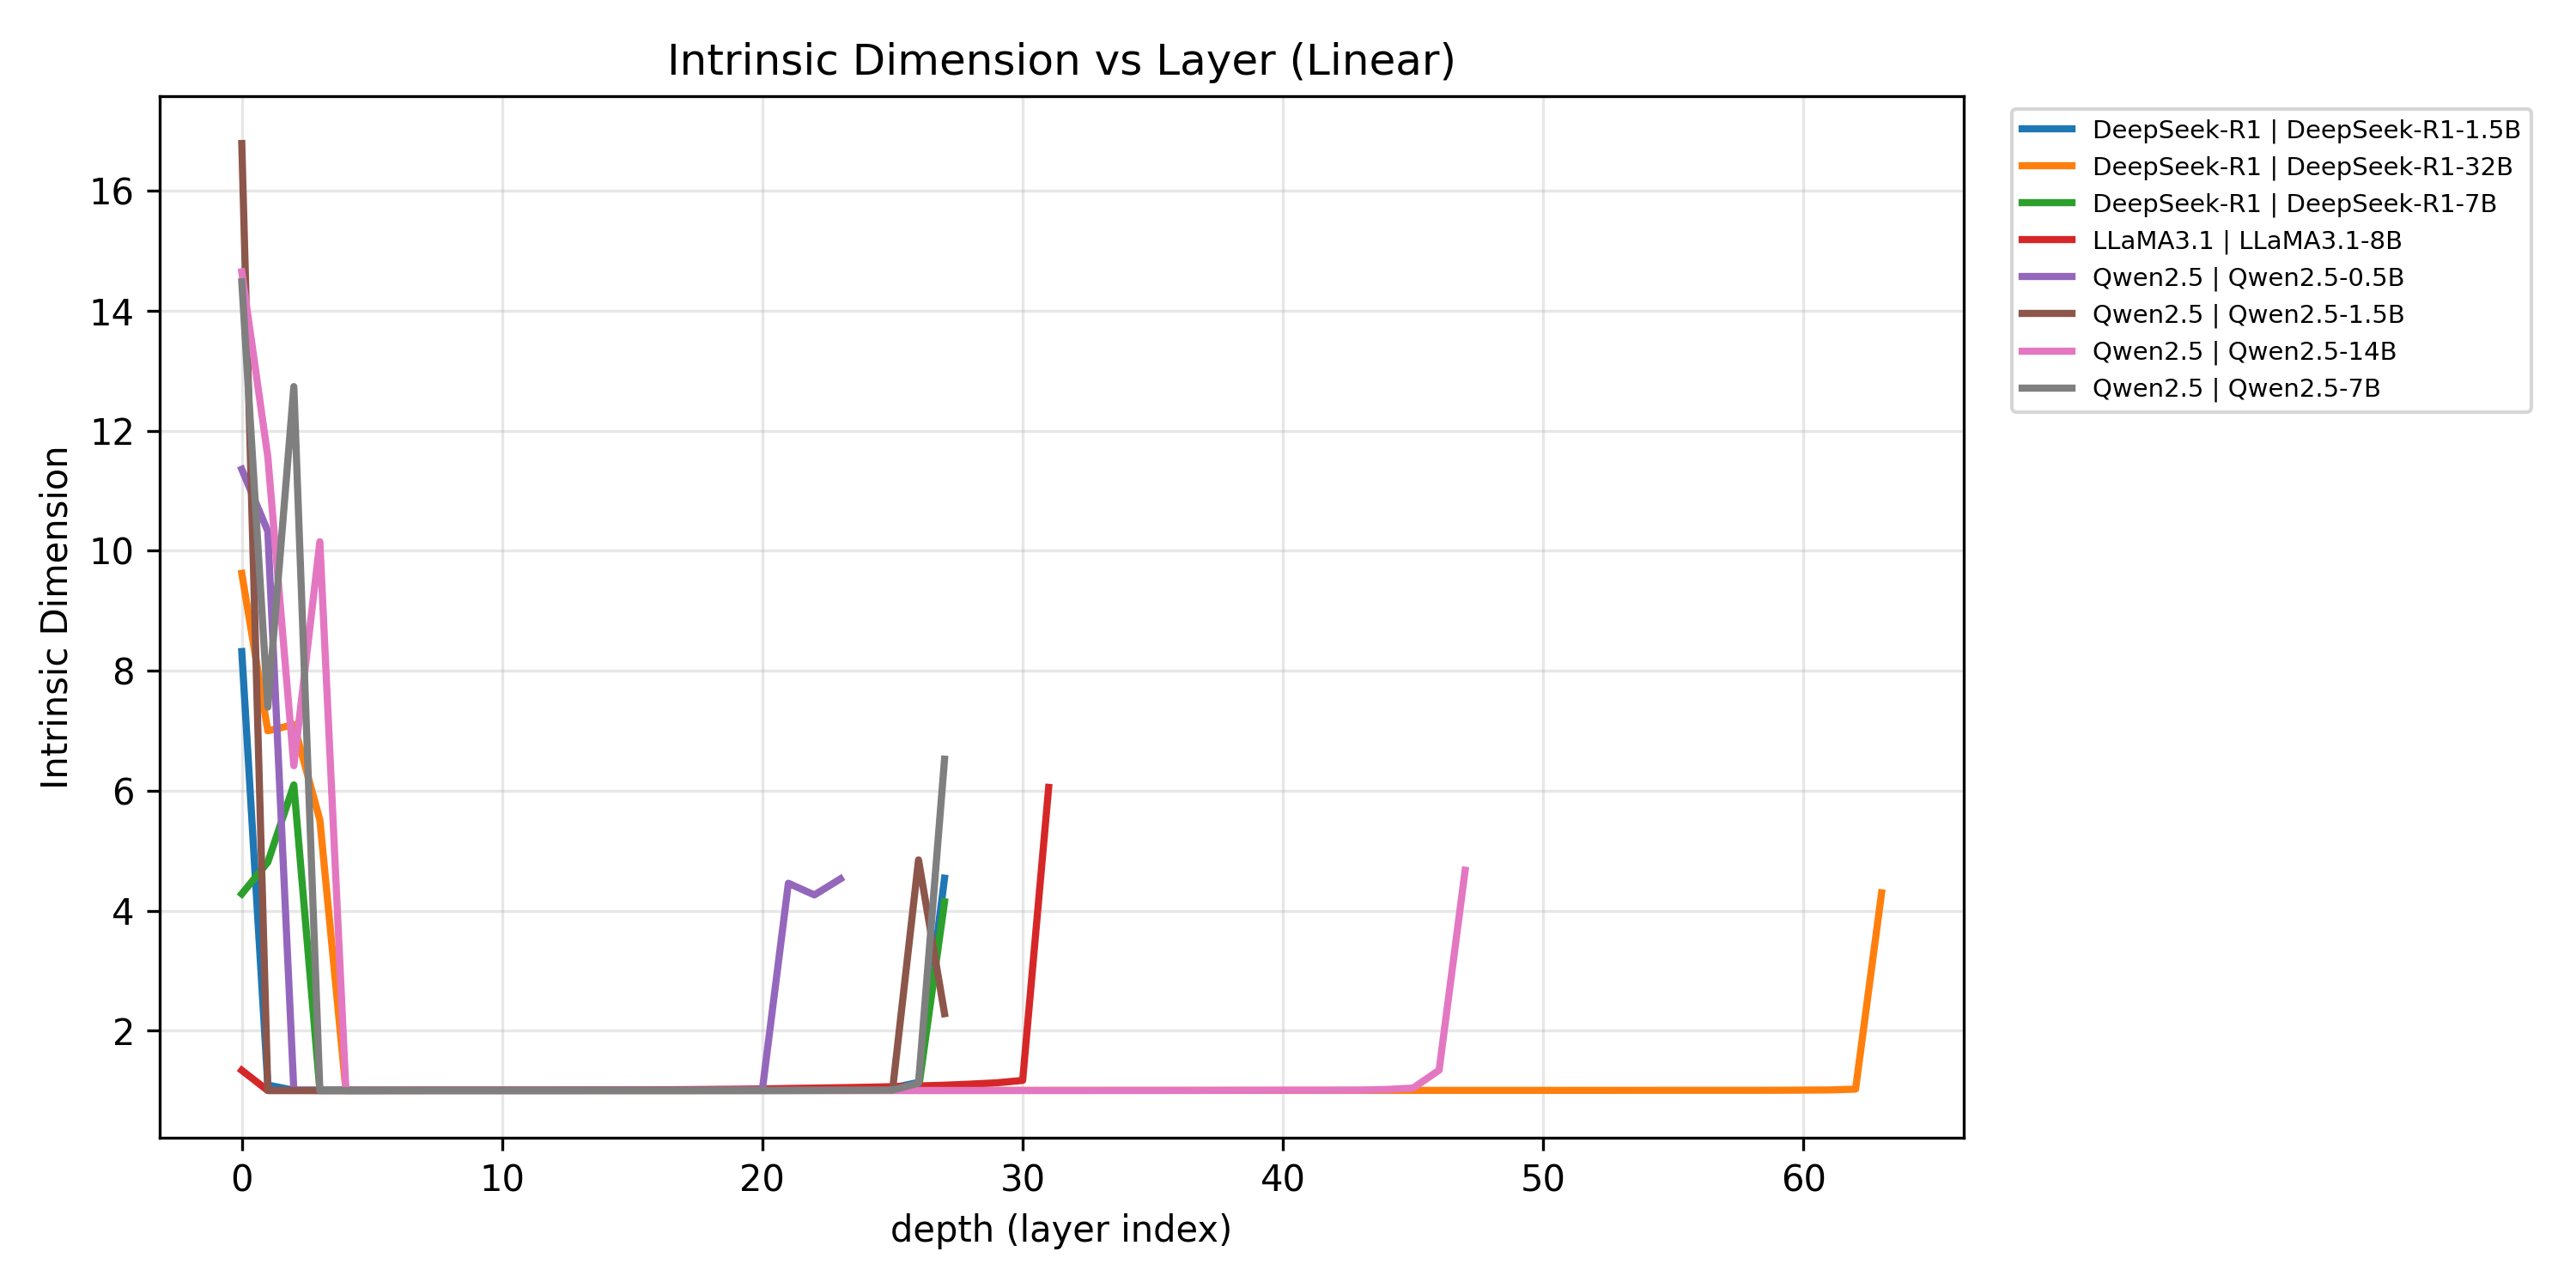

# 4. What does the Intrinsic Dimension (ID) module do?
# 4. 内在维度（ID）模块的作用是什么？

The **LayerRepresentationIntrinsicDimension** metric describes how to **estimate the effective degrees of freedom** of neural representations.  
这个指标用于**估计神经网络表征的有效自由度**。

It builds on the metric base/registry in `deepct.metrics`, and implements methods that:  
它基于 `deepct.metrics` 的基类/注册表实现，并完成以下三件事：

1) **collect hidden states** from Transformer layers;  
（1）从各层收集 **hidden states（隐藏向量）**；  

2) **standardize/center** them for comparability;  
（2）对数据进行 **标准化/中心化** 以便可比；  

3) **compute an intrinsic-dimension estimate** (e.g., Participation Ratio) **per layer**.  
（3）为每一层计算 **内在维度估计**（如 **参与度比率**）。


> **Note.** The words *class*, *subclass*, and *methods* refer to object-oriented programming (OOP) concepts.  
> **注：** *class*、*subclass*、*methods* 为面向对象（OOP）的常用术语。

The ID module also provides a unified way to **hook** models, select **which layers** to probe, and **batch/stream** tokens safely to keep memory usage under control.  
该模块还提供统一的 **hook（挂钩）** 机制以选择需要观测的 **层**，并支持 **批量/流式** 读取以控制显存占用。

---

## 4.1 Hidden Vectors
## 4.1 隐藏向量

For a given input, each Transformer layer outputs a set of **hidden vectors** (one per token). Stacking those vectors (tokens × hidden_dim) yields a data matrix \( X \).  
对给定输入，每个 Transformer 层都会输出一组 **隐藏向量**（每个 token 一条）。把这些向量堆叠（tokens × hidden_dim）就得到数据矩阵 \( X \)。

Intuitively, the **intrinsic dimension** asks: *how many independent directions in the hidden space are effectively used by the data?*  
直观上，**内在维度**在回答：*这些隐藏向量在隐空间里实际“用到”了多少个独立方向？*

---

## 4.2 Representation Space
## 4.2 层表示空间

For each layer \(\ell\), the set of hidden vectors forms a **representation space**. The ID module estimates **how many directions** in this space are effectively used by the data.  
对每一层 \(\ell\)，隐藏向量共同构成该层的**表示空间**。ID 模块评估在该空间中被数据**实际利用的方向数**。

A common estimator is the **Participation Ratio (PR)** based on the singular values \((s_i)\) of \(X\):  
常用估计器是基于 \(X\) 的奇异值 \((s_i)\) 的 **参与度比率（PR）**：

$$
\mathrm{ID}(X) \;=\; \frac{\left(\sum_i s_i^2\right)^{2}}{\sum_i s_i^4}\,.
$$

**Interpretation ｜ 解释：**

- A **higher ID** implies information is spread across **more directions** (less compression).  
  **ID 高** ⇒ 信息分布在 **更多方向** 上（压缩较弱）。

- A **lower ID** implies information collapses to **fewer directions** (strong compression).  
  **ID 低** ⇒ 信息集中到 **少数方向**（压缩更强）。

As we move deeper into the network, many models exhibit a **layer-wise decrease** in ID, indicating **progressive compression** and the formation of **compact, task-specific subspaces**.  
随着网络加深，许多模型会出现 **ID 随层递减** 的现象，表明表征在逐层 **渐进压缩**，并逐步形成 **紧致的任务相关子空间**。


# 5. How is the Intrinsic Dimension (ID) module structured?  
# 5. 内在维度（ID）模块是如何组织的？

The ID module is implemented as a metric class that follows a **reset → update → compute** lifecycle.  
该模块以度量类实现，遵循 **reset → update → compute** 的生命周期。

- **Reset** clears internal buffers for a fresh run.  
  **Reset**：清空内部缓冲，开始一次新的度量。  
- **Update** ingests one layer’s hidden vectors (possibly many batches).  
  **Update**：逐批/逐层喂入隐藏向量（可多次调用）。  
- **Compute** returns a dictionary of **per-layer ID values**.  
  **Compute**：返回**逐层的 ID 数值**字典。

---

## 5.1 Public Interface & Lifecycle  
## 5.1 对外接口与生命周期

This section specifies **what the Intrinsic Dimension (ID) module exposes**, the **contract of its methods**, and the **end-to-end data flow**. It also defines **naming, shapes, tap points, and invariants** so runs are comparable and reproducible across models and experiments.  
本节明确 **ID 模块对外提供的内容**、**方法契约** 与 **端到端数据流**，并规定 **命名、张量形状、采样口径（tap point）与不变量**，以确保不同模型/实验间结果可比、可复现。

---

### A. Responsibilities of the module  
### A. 模块职责

- **Collect layer representations** in a consistent way (e.g., post-norm outputs of each Transformer block).  
  **一致采样** 各层表示（如每个 Transformer 块的 post-norm 输出）。
- **Accumulate features safely** under a token budget (streaming updates; no giant concatenations).  
  在 **token 配额** 下安全 **累积特征**（流式 `update`；避免一次性拼巨矩阵）。
- **Normalize according to policy** (centering / optional standardization).  
  按策略进行 **归一化**（去均值 / 可选标准化）。
- **Estimate layer-wise ID** using the agreed estimator (Participation Ratio, PR).  
  用约定的估计器（PR）计算 **逐层 ID**。
- **Report results** in stable, machine-readable formats (per-layer dict + optional aggregates).  
  以 **可读且可机读** 的格式输出（逐层字典 + 可选汇总）。

---

### B. Method contract (lifecycle)  
### B. 方法契约（生命周期）

**Lifecycle｜生命周期：** `reset → update → compute`

1) **`reset()`**  
   - Clears all internal buffers and statistics.  
   - Starts a fresh accumulation pass.  
   **清空** 内部缓存与统计，开始新一轮累计。

2) **`update(layer_name, hidden_states)`**  
   - **Input shapes｜输入形状**：`[B, T, D]` 或展平为 `[N, D]`；`B`=批大小，`T`=序列长度，`D`=隐藏维度。  
   - **Masking｜掩码**：应当 **排除 padding**；对 BOS/EOS 的纳入与否需 **全程一致**。  
   - **Tap point｜采样口径**：须与实验口径一致（`prenorm` 或 `postnorm`），并在报告中注明。  
   - **Token budget｜配额**：逐层累计到 `max_tokens` 即 **早停** 该层的后续累计。  
   - **Normalization｜归一化**：如 `center=True`，在层内 **去均值**；可选标准化需保持跨实验一致。  
   - **Multiple calls｜多次调用**：同一层可多次 `update`（流式/分批），“谁先到达配额谁先停”。  
   - **No side effects｜无副作用**：不得在 `update` 中改变外部模型状态。  

3) **`compute() -> Dict[str, float]`**  
   - Consolidates per-layer buffers, applies the estimator (PR), and returns `layer → id_value`.  
   - Optionally produces **aggregates** (mean/median across layers), with clear definitions.  
   汇总逐层缓存，应用估计器（PR），返回 `层名 → ID 值`；可选输出 **层间汇总指标**（均值/中位数等），并明确其定义。

---

### C. Naming, scope, and shapes  
### C. 命名、范围与形状

- **Layer names｜层名**：建议采用 `encoder.layer.k` / `decoder.layer.k` / `transformer.h.k` 等 **可追溯命名**，与原模型结构一一对应。  
- **Scope｜范围**：默认 **不** 含嵌入层（embeddings），从第 1 个 Transformer 块开始统计；是否包含可在报告中声明。  
- **Shapes｜形状**：模块内部一律在层内聚合为二维矩阵 \(X\in\mathbb{R}^{N\times D}\)，其中 \(N\) 为累计 token 数。

---

### D. Policy invariants (comparability)  
### D. 策略不变量（可比性）

To compare across models/sessions, the following **must remain identical** unless explicitly stated:  
跨模型/多次实验的 **对比前提**（除非特别说明，下列策略需保持一致）：

1. **Tap point**：统一 `prenorm` 或 `postnorm`。  
2. **Centering**：是否 `center=True`。  
3. **Token budget**：每层 `max_tokens` 与采样/截断策略。  
4. **Prompt set**：提示数据版本、主题/语言/长度分布与去重策略。  
5. **Precision**：运算精度（FP16/FP32）与数值稳定性选项。  
6. **Masking**：padding & BOS/EOS 的处理规则。  

> Any divergence from the above must be **documented** in the run metadata and report headers.  
> 以上任一策略如有变化，**必须** 在运行元数据与报告抬头中 **明确记录**。

---

### E. Inputs & outputs (I/O schema)  
### E. 输入与输出（I/O 约定）

**Inputs ｜ 输入**  
- **Required**：`hidden_states`（逐层特征）、`layer_name`（唯一标识）。  
- **Optional**：`center`、`precision`、`max_tokens`、`tap`（在构造或配置层面给出，不建议在运行中反复改动）。  

**Outputs ｜ 输出**  
- **Per-layer map**：`{ "encoder.layer.0": id0, "encoder.layer.1": id1, ... }`。  
- **Aggregates (optional)**：`{"mean_id": …, "median_id": …, "early_slope": …}`（如提供，需清晰定义计算口径）。  
- **Provenance**：建议附带 **run metadata**（模型标识、版本、tap、budget、precision、prompt 统计、时间/设备信息等）。

---

### F. Logging & reproducibility metadata  
### F. 日志与复现元数据

Runs should emit a minimal, consistent set of metadata to make results audit-ready:  
为便于审计与复现，运行过程应输出以下 **最小一致** 元数据：

- **Environment**：`python/torch/transformers`/CUDA/cuDNN 版本（可附 `pip freeze` 摘要）。  
- **Model**：`model_id`、权重来源（HF/本地路径）、是否有自定义修改。  
- **Data**：提示文件版本与统计（条数、词长分布、主题/语言比例、去重策略）。  
- **Policy**：`tap`（pre/post-norm）、`center`、`max_tokens`、precision、masking 规则。  
- **Command/Config**：完整命令/配置（便于一键复跑）。  
- **Resources**：设备/显存、耗时、内存峰值。  
- **Hashing**：可选输出结果与输入的短哈希校验，防止意外篡改。

---

### G. Error handling & guardrails  
### G. 异常处理与保护栏

- **Budget guard**：超配额即早停该层累计，并在日志中提示 **实际累计 N**。  
- **Shape guard**：非 `[B, T, D] / [N, D]` 形状或空张量 → 记录并跳过。  
- **Mask guard**：若发现未掩码的 padding，将在日志中发出 **显式警告**。  
- **Policy drift**：检测到与既定口径（tap/center/precision 等）不一致时，强制提示并拒绝计算或要求显式确认。  
- **Numerics**：当谱极度尖锐导致数值不稳时，记录警示并建议 **切换 FP32 / 调整 budget / 启用中心化**。

---

In [ ]:
# 5.1 Minimal lifecycle smoke test: reset → update → compute
import torch
torch.manual_seed(42)

# ---- PR estimator（供演示用；5.3里会给更完整版本）----
def compute_id_pr(X: torch.Tensor) -> float:
    """
    X: [N, D] float32/float16
    returns: scalar ID via Participation Ratio
    """
    Xf = X.float()
    # SVD 的数值更稳健；这里用奇异值
    # 对较大的 N 可考虑随机SVD但演示用全SVD够用
    S = torch.linalg.svdvals(Xf)
    num = (S.pow(2).sum())**2
    den = (S.pow(4).sum()) + 1e-12
    return (num / den).item()

# ---- 模拟模块的 reset / update / compute 流程 ----
class IDMetricDemo:
    def __init__(self, max_tokens=4096, center=True):
        self.max_tokens = max_tokens
        self.center = center
        self.reset()

    def reset(self):
        self._buf = {}  # layer_name -> list[Tensor[N,D]]

    def update(self, layer_name, hidden_states):
        """
        hidden_states: [B, T, D] 或 [N, D]
        这里用随机数据模拟
        """
        H = hidden_states
        if H.dim() == 3:
            H = H.reshape(-1, H.shape[-1])  # -> [N,D]
        if self.center:
            H = H - H.mean(dim=0, keepdim=True)
        # 截断到配额
        if self.max_tokens and H.shape[0] > self.max_tokens:
            H = H[: self.max_tokens]
        self._buf.setdefault(layer_name, []).append(H)

    def compute(self):
        out = {}
        for name, chunks in self._buf.items():
            X = torch.cat(chunks, dim=0)
            out[name] = compute_id_pr(X)
        return out

# ---- 构造两层的随机隐藏向量，演示完整流程 ----
D = 128               # 隐藏维度
B, T = 8, 64          # 批与长度（这里只是演示）
metric = IDMetricDemo(max_tokens=4096, center=True)
metric.reset()

# 模拟 encoder.layer.0 和 encoder.layer.1
h0 = torch.randn(B, T, D)         # 第一层
h1 = torch.randn(B, T, D) * 0.6   # 第二层（人为做点“压缩”）

metric.update("encoder.layer.0", h0)
metric.update("encoder.layer.1", h1)
id_map = metric.compute()

print("=== 5.1 Lifecycle demo (random data) ===")
for k, v in id_map.items():
    print(f"{k}: {v:.3f}")


## 5.2 Data Policy (Sampling & Normalization)  
## 5.2 数据策略（采样与归一化）

**(1) Tap point & comparability｜采样口径与可比性**  
Adopt **one** tap point for the entire study（推荐 **post-norm** 的层输出），并在元数据中清楚记录。跨模型/多轮对比时，以下口径必须对齐，且在报告抬头显式标注：  
- **Tap**：`prenorm` / `postnorm` 二选一，全程保持一致；  
- **Special tokens & masking**：是否纳入 **BOS/EOS**、如何处理 **padding 掩码**（必须统一）；  
- **Prompt set**：固定文件/版本与构成（长度分布、主题/语言占比、去重策略）；  
- **Token budget & precision**：每层 `max_tokens`、截断/采样策略、数值精度（FP16/FP32）。  
**解读要点**：Tap 改变将影响绝对 ID 值；若口径不统一，任何横向比较都可能失真。

---

**(2) Data & budget｜数据与配额**  
准备能够覆盖真实使用场景的 **多样化提示集**（长度/主题/风格/语言），并**去重**；为便于复现，固定文件版本并给出基础统计。为每一层设置 **`max_tokens` 上限**（常见 4k–16k），**达到即早停**该层的后续累计；优先使用**流式 `update()`**，避免一次性拼接巨矩阵。累计时统一张量形状为 `[B, T, D]`（或稳定地展平为 `[N, D]`）。  
- **起步建议**：从 4k token/层开始，若 ID 曲线抖动较大再提升到 8k/16k；  
- **长度与截断**：若存在截断，比较组需**同策略**（同样的最大长度与截断位置）；  
- **排序与批次**：估计器与样本顺序无关，但为复现性应固定批次顺序与随机种子。  
**解读要点**：更高的 token 配额通常让 PR 更稳定，但成本更高；先小后大、逐步校准。

---

**(3) Normalization & precision｜归一化与数值精度**  
在层内启用 **去均值 `center=True`**，通常能显著稳定奇异值谱；若使用标准化（如按特征标准差缩放），需**固定作用范围**（逐层/全局）并在所有运行中保持一致。默认 **FP16** 足以得到稳健的 PR；对外报告或关键结论建议**再用 FP32 复核一次**。  
- **确定性**：固定随机种子，记录可能影响确定性的环境变量（如 cuDNN/cuBLAS 设置）；  
- **数值防护**：当谱极尖锐导致不稳（ID 波动、SVD 告警），优先：① 保持/开启去均值；② 适度增大 `max_tokens`；③ 切换 FP32 复核；  
- **可比性提示**：`center/standardize` 的开关与范围若改变，必须在报告中注明并避免与旧口径直接对比。  
**解读要点**：Normalization 是稳定 PR 的“开关变量”；精度从 FP16→FP32 的切换用于关键节点的稳健性验证。


In [ ]:
# 5.2A Prompt set stats + optional masking check
import re, collections
import numpy as np
import matplotlib.pyplot as plt

def load_prompts(path, dedup=True):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    if dedup:
        # 简单去重（大小写无关 / 空白压缩）
        norm = lambda s: re.sub(r"\s+", " ", s.lower())
        uniq = {}
        for s in lines:
            uniq.setdefault(norm(s), s)
        lines = list(uniq.values())
    return lines

def prompt_stats(prompts):
    lengths = [len(p.split()) for p in prompts]
    stats = {
        "count": len(prompts),
        "avg_len": float(np.mean(lengths)) if lengths else 0.0,
        "p50_len": float(np.percentile(lengths, 50)) if lengths else 0.0,
        "p90_len": float(np.percentile(lengths, 90)) if lengths else 0.0,
    }
    return stats, lengths

# 如需做掩码检查（需要你已有 tokenizer + batch inputs）
def check_masking(attention_mask, include_bos_eos=True):
    """
    attention_mask: [B, T] 1=valid 0=pad
    include_bos_eos: 是否计入 BOS/EOS；这里仅做标记提示
    """
    mask = attention_mask
    pad_ratio = float((mask == 0).sum() / mask.numel())
    print(f"[Masking] padding ratio = {pad_ratio:.4f}, BOS/EOS policy = {'include' if include_bos_eos else 'exclude'}")
    return pad_ratio

# ------- 使用示例（按需修改路径）-------
# prompts_path = "data/prompts.txt"  # 你的提示文件路径
# prompts = load_prompts(prompts_path, dedup=True)
# stats, lens = prompt_stats(prompts)
# print("Prompt stats:", stats)

# 可视化长度分布（可选）
# if lens:
#     plt.figure(figsize=(5,3))
#     plt.hist(lens, bins=20)
#     plt.title("Prompt length distribution")
#     plt.xlabel("length (words)")
#     plt.ylabel("count")
#     plt.tight_layout()
#     plt.show()

# 掩码检查（需要你已经做好 batch tokenization）
# from transformers import AutoTokenizer
# tok = AutoTokenizer.from_pretrained("bert-base-uncased")
# inputs = tok(prompts[:32], return_tensors="pt", padding=True, truncation=True)
# _ = check_masking(inputs["attention_mask"], include_bos_eos=True)


In [ ]:
# 5.2B Centering / normalization policy demo
import torch

def center_features(X: torch.Tensor, do_center: bool = True):
    """
    X: [N, D] or [B, T, D]
    返回：同形状张量，若 do_center=True 则逐特征去均值
    """
    H = X
    if H.dim() == 3:
        H = H.reshape(-1, H.shape[-1])  # -> [N, D]
        shape = X.shape
        need_reshape = True
    else:
        need_reshape = False
        shape = None
    if do_center and H.numel() > 0:
        H = H - H.mean(dim=0, keepdim=True)
    if need_reshape:
        H = H.reshape(*shape)
    return H

# 演示：随机张量去均值前后，均值接近 0
# rnd = torch.randn(1024, 256)
# rnd_c = center_features(rnd, do_center=True)
# print(float(rnd.mean()), "->", float(rnd_c.mean()))


## 5.3 Estimator & Interpretation  
## 5.3 估计器与解释

**(1) Definition (Participation Ratio, PR)｜定义（参与度比率）**  
Let the stacked hidden-state matrix be \(X \in \mathbb{R}^{N \times D}\) with singular values \(\{s_i\}_{i=1}^{\min(N,D)}\).  
ID via **Participation Ratio (PR)** is:
\[
\mathrm{ID}(X)=\frac{\Big(\sum_{i} s_i^{2}\Big)^{2}}{\sum_{i} s_i^{4}} \;\;=\;\frac{\|X\|_{F}^{4}}{\|X^{\top}X\|_{F}^{2}}\,.
\]
- **Energy view｜能量视角**：把 \(s_i^{2}\) 视为第 \(i\) 个主方向的能量；能量越分散，分子增幅相对更大 → **ID 更高**；能量越集中，分母主导 → **ID 更低**。  
- **Range｜取值范围**：\(1 \le \mathrm{ID}(X) \le \mathrm{rank}(X)\)。当能量平均分布在 \(k\) 个方向上，\(\mathrm{ID}(X)\approx k\)。

---

**(2) Reading the curve｜读图与解读**  
For layer-wise ID \(\{\mathrm{ID}_\ell\}\) across Transformer depth \(\ell=0,1,\dots,L-1\):  
- **Monotone decline (typical)｜单调下降（常见）**：\(\mathrm{ID}_\ell\) 随层数加深逐步降低，表示**逐层压缩与抽象**；早期层保持较高自由度，中后期层出现**维度塌缩**。  
- **Slope & knee｜斜率与“拐点”**：前中段斜率越大 → 压缩越剧烈；“拐点”位置可视为**表达从通用向任务专化转变**的层位标记。  
- **Across models｜跨模型比较**：更大/更强模型常在更深层维持较高 ID（**延迟塌缩**），而最终层往往收敛到相近的低维区间（如 \(\approx 2\!-\!5\)），反映**共享的高层抽象**。

---

**(3) Practical cautions｜实践注意**  
- **Policy sensitivity｜口径敏感**：\(\mathrm{ID}\) 对 **tap 点（pre/post-norm）**、**去均值策略**、**token 配额** 与 **提示分布** 敏感；对比时务必统一口径并在报告中标注。  
- **Estimator nature｜估计器本质**：PR 是“有效维度”的统计估计；用于**内部表征分析与可比性**，不替代任务指标（准确率、困惑度等）。  
- **Robustness checks｜稳健性校验**：对关键结论，建议做 **FP16→FP32 复核**、**不同 `max_tokens`** 与 **不同提示子集** 的敏感性分析，确认趋势非偶然。

### Run notes (inside 5.3)  
**Purpose｜目的**：在不新增章节的情况下，给出最小可复现实验流程（命令行 / 脚本 / 配置），与 5.1–5.3 一致口径。

**Inputs｜输入**：`model`、`prompts`（固定版本并记录统计）、`max_tokens`（每层配额）、`tap`（prenorm/postnorm）、`center`（是否去均值）、`precision`（FP16/FP32）。

**Protocol｜协议**：统一采样点（推荐 post-norm）、统一去均值策略（`center=True`）、统一配额与掩码规则（padding、BOS/EOS），并在元数据中记录环境/命令/设备/耗时。

**Outputs｜输出**：逐层 ID 的 JSON（layer → ID），附摘要曲线（ID vs. Layer）与运行元数据（版本/命令/显存/耗时）。


In [ ]:
# 5.3 Run notes — CLI (paste into terminal or Bash cell)
export CUDA_VISIBLE_DEVICES=0
export PYTHONHASHSEED=42

# 最小示例
python run_id_eval.py \
  --model bert-base-uncased \
  --prompts data/prompts.txt \
  --max_tokens 4096 \
  --fp16 \
  --tap postnorm \
  --center \
  --output results/bert_id_report.json


In [ ]:
# 5.3 Run notes — minimal entry script (save as run_id_eval.py)
import argparse, json, torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from deepct.metrics.layer_representation_intrinsic_dimension import (
    LayerRepresentationIntrinsicDimension as ID
)

def read_prompts(path: str):
    with open(path, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--model", required=True)
    ap.add_argument("--prompts", required=True)
    ap.add_argument("--max_tokens", type=int, default=4096)
    ap.add_argument("--fp16", action="store_true")
    ap.add_argument("--tap", choices=["prenorm", "postnorm"], default="postnorm")
    ap.add_argument("--center", action="store_true")
    ap.add_argument("--output", type=str, default="results/id_report.json")
    args = ap.parse_args()

    tok = AutoTokenizer.from_pretrained(args.model)
    model = AutoModel.from_pretrained(args.model).eval()

    prompts = read_prompts(args.prompts)
    inputs = tok(prompts, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True, use_cache=False)
    hidden_list = list(out.hidden_states)[1:]  # 跳过 embedding 层

    metric = ID(max_tokens=args.max_tokens, use_fp16=args.fp16, center=args.center)
    metric.reset()
    for li, h in enumerate(hidden_list, start=0):
        if h.dim() == 3:
            h = h.reshape(-1, h.shape[-1])  # [N,D]
        if h.shape[0] > args.max_tokens:
            h = h[: args.max_tokens]
        if args.center:
            h = h - h.mean(0, keepdim=True)
        metric.update(f"encoder.layer.{li}", h)

    res = metric.compute()
    Path(args.output).parent.mkdir(parents=True, exist_ok=True)
    with open(args.output, "w", encoding="utf-8") as f:
        json.dump(res, f, indent=2, ensure_ascii=False)
    print(f"[saved] {args.output}")

if __name__ == "__main__":
    main()


In [ ]:
# 5.3A Participation Ratio (PR) estimator
import torch

def compute_id_pr(X: torch.Tensor) -> float:
    """
    X: [N, D] tensor, typically centered.
    Returns: scalar PR-based Intrinsic Dimension
    数学式：ID = (sum s_i^2)^2 / (sum s_i^4)
    """
    if X.dim() != 2:
        raise ValueError("compute_id_pr expects [N, D] matrix")
    Xf = X.float()
    # 需要更快可考虑 randomized SVD；这里全SVD更稳健
    S = torch.linalg.svdvals(Xf)  # [min(N,D)]
    num = (S.pow(2).sum())**2
    den = (S.pow(4).sum()) + 1e-12
    return (num / den).item()

# # 简单单测（随机均匀能量分布时，ID ~ 有效方向数）
# H = torch.randn(4096, 64)
# print("ID:", compute_id_pr(H))


In [ ]:
# 5.3B Layer-wise ID with optional real hidden_states
import torch
import matplotlib.pyplot as plt

def layerwise_id_from_hidden_list(hidden_list, center=True, max_tokens=8192):
    """
    hidden_list: list of layer outputs；每个元素形状 [B,T,D] 或 [N,D]
                 一般可以直接使用 transformers outputs.hidden_states[1:]
    returns: (layers, id_values)
    """
    layers, values = [], []
    for li, h in enumerate(hidden_list):
        H = h
        if H.dim() == 3:
            H = H.reshape(-1, H.shape[-1])  # -> [N,D]
        if H.shape[0] > max_tokens:
            H = H[:max_tokens]
        if center:
            H = H - H.mean(dim=0, keepdim=True)
        id_val = compute_id_pr(H)
        layers.append(li)
        values.append(id_val)
    return layers, values

# ========== 用法1：你已经有真实 hidden_states ==========
# 假设你在上文的推理里拿到了：
# with torch.no_grad():
#     outputs = model(**inputs, output_hidden_states=True, use_cache=False)
# hidden_list = list(outputs.hidden_states)[1:]  # 跳过 embedding 层
# layers, ids = layerwise_id_from_hidden_list(hidden_list, center=True, max_tokens=8192)

# ========== 用法2：没有真实 hidden_states，就用随机张量演示 ==========
# 方便让图能先跑通
if "layers" not in globals():
    torch.manual_seed(0)
    L, D = 6, 256
    B, T = 8, 64
    fake_hidden = []
    for li in range(L):
        scale = 1.0 - 0.1 * li  # 越往后越“压缩”
        fake_hidden.append(torch.randn(B, T, D) * max(scale, 0.3))
    layers, ids = layerwise_id_from_hidden_list(fake_hidden, center=True, max_tokens=4096)

# 画 ID vs. Layer 曲线
plt.figure(figsize=(6,4))
plt.plot(layers, ids, marker="o", linewidth=2)
plt.xlabel("Layer index")
plt.ylabel("Intrinsic Dimension (PR)")
plt.title("Layer-wise ID")
plt.grid(True)
plt.tight_layout()
plt.show()

# 也把数值打印出来，便于复制到报告
print("=== Layer-wise ID values ===")
for li, v in zip(layers, ids):
    print(f"layer {li}: {v:.3f}")


# Conclusion  
# 结论

**Summary｜总结**  
The Intrinsic Dimension (ID) module offers a principled, light-weight probe of **layer-wise representational complexity** in Transformer models.  
通过统一的 `reset → update → compute` 生命周期与稳定的 **PR 估计器**，它在可控资源下刻画**逐层表征自由度**，为理解 **压缩—抽象** 的层级机制提供了可比口径。

- **What we measured｜测得了什么**：在统一 **tap 点**、**去均值策略** 与 **token 配额** 下，按层累积 hidden states，基于奇异值谱计算 **Participation Ratio (PR)**，得到 *layer → ID* 曲线。  
- **What we learned｜得到的认识**：多数模型随深度 **ID 递减**（逐层压缩），大模型往往 **延迟塌缩**，末层收敛到相近低维区间（≈2–5），提示不同架构在高层抽象上存在**共性模式**。  
- **How to trust it｜如何确保可信**：统一口径（tap/center/precision/budget）、丰富而可复现的提示集、以及对关键结论的 **FP32 复核与配额敏感性分析**。

**Limitations｜局限**  
ID 是“**模型 × 数据**”的联合属性；不同提示分布会改变曲线。PR 为统计估计，不能替代任务指标；**采样点（pre/post-norm）**、**是否中心化** 与 **token 配额** 会显著影响绝对数值。因此，结论应被解读为**表征几何的相对比较**与**趋势洞察**，而非任务性能的直接替代。

**Recommended practice｜推荐实践**  
1) 固定一套可复现的实验协议：tap、center、precision、`max_tokens`、prompt 版本与统计；  
2) 先以 **4k/层** 启动，观察曲线稳定性后升至 **8k/16k**；  
3) 对关键发现执行 **FP16→FP32 复核** 与 **不同配额/子集** 的敏感性检查；  
4) 报告中附上 **逐层 ID JSON**、摘要曲线与运行元数据（环境/命令/设备/耗时）。

**Outlook｜展望**  
未来可结合 **任务损失/梯度信号** 以及 **注意力头/子空间级** 的细粒度度量，进一步关联 **ID 曲线形态** 与 **泛化/稳健性/可压缩性**；亦可探索与 **流形曲率、各向异性指标** 的联合分析，构建更完整的**信息几何画像**。

**One-line takeaway｜一句话结论**  
> **Layer-wise ID turns hidden-state spectra into a comparable curve of representational freedom—simple to run, insightful to compare, and reliable when the protocol is consistent.**  
> **逐层 ID 将隐藏向量谱转化为可比的“表征自由度”曲线——易于运行、便于对比、在统一口径下具备可靠解释力。**
